In [1]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Set TensorFlow to use GPU (if available)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is enabled and TensorFlow will use it.")
    except RuntimeError as e:
        print(e)

2025-03-24 10:07:25.000386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742810845.013913    2774 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742810845.017929    2774 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 10:07:25.032782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available: 1
GPU is enabled and TensorFlow will use it.


In [2]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.api.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.api.models import Sequential
from keras.api.applications import VGG16
from keras.api.optimizers import Adam

In [3]:
train_dir = "/workspace/sdp/redd/train"
test_dir = "/workspace/sdp/redd/test"

In [4]:
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def apply_gamma_correction(image, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)


def preprocess_image(image):
    image = (image * 255).round().astype(np.uint8)

    # Apply CLAHE and Gamma Correction
    image = apply_clahe(image)
    image = apply_gamma_correction(image)

    # Convert back to float32 [0, 1] for the model
    return image.astype(np.float32) / 255

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    preprocessing_function=preprocess_image,  # Use your custom function directly
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image  # Apply preprocessing to test set as well
)


# Load Training & Testing Data
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 15000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [21]:
# Load Pretrained VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model

# Define Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,299 (56.76 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
import pickle

epochs = 5
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=epochs
)
model.save("my_model-ilu-gp.h5")
with open("history-ilu-gp.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("Model and training history saved successfully!")


Epoch 1/5


I0000 00:00:1742805012.921113    1418 service.cc:148] XLA service 0x7fac30006600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742805012.921617    1418 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-03-24 08:30:13.003068: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742805013.323657    1418 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-24 08:30:13.835006: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1398_0', 8 bytes spill stores, 8 bytes spill loads

2025-03-24 08:30:14.712597: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_

  2/469 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.2422 - loss: 1.1867   

I0000 00:00:1742805021.189949    1418 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


248/469 ━━━━━━━━━━━━━━━━━━━━ 1:51 506ms/step - accuracy: 0.4185 - loss: 1.0787

2025-03-24 08:32:27.370526: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1398', 16 bytes spill stores, 16 bytes spill loads

2025-03-24 08:32:27.760112: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2056', 36 bytes spill stores, 36 bytes spill loads

2025-03-24 08:32:27.895737: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2056', 36 bytes spill stores, 36 bytes spill loads

2025-03-24 08:32:28.176983: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2056', 24 bytes spill stores, 24 bytes spill loads



469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.4827 - loss: 0.9958

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 310s 641ms/step - accuracy: 0.4830 - loss: 0.9954 - val_accuracy: 0.8220 - val_loss: 0.4805
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 190s 405ms/step - accuracy: 0.7331 - loss: 0.5966 - val_accuracy: 0.8493 - val_loss: 0.3727
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 384ms/step - accuracy: 0.7761 - loss: 0.5065 - val_accuracy: 0.8657 - val_loss: 0.3302
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 185s 394ms/step - accuracy: 0.7972 - loss: 0.4660 - val_accuracy: 0.8700 - val_loss: 0.3119
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 186s 396ms/step - accuracy: 0.8075 - loss: 0.4434 - val_accuracy: 0.8807 - val_loss: 0.2911


Model and training history saved successfully!


In [24]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"\n🔹 Test Accuracy after initial training: {test_accuracy * 100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.8901 - loss: 0.2743

🔹 Test Accuracy after initial training: 88.07%


In [27]:
# Fine-Tuning (Unfreeze last 10 layers)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Keep first layers frozen
    layer.trainable = False

# Recompile Model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from keras.api.optimizers import Adam

fine_tune_epochs = 2
# Reduce learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune
history_fine = model.fit(
    training_set,
    validation_data=test_set,
    epochs=fine_tune_epochs, verbose=2
)
model.save("my_model-f-gpu-ilu.h5")

In [8]:
import pickle

file_path = r"D:\sdp\sl-two-gpu\history-ilu-gp.pkl"

# Attempt to open and check the contents
try:
    with open(file_path, "rb") as f:
        history = pickle.load(f)
    print("History loaded successfully!")
    print(history.keys())  # Print available keys
except Exception as e:
    print(f"Error loading file: {e}")


History loaded successfully!
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


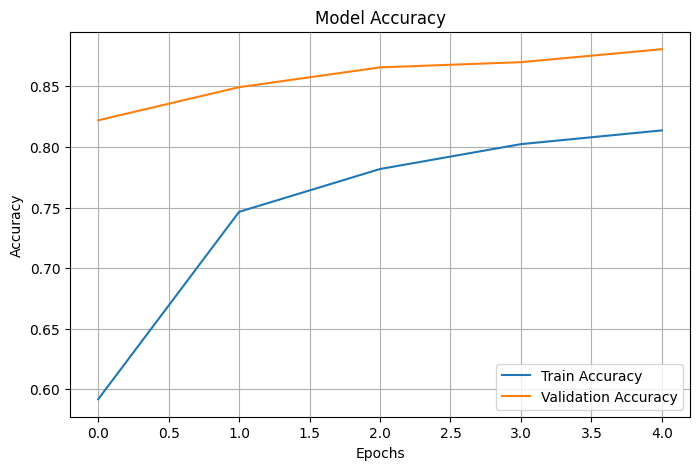

In [11]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    if 'accuracy' in history and 'val_accuracy' in history:
        plt.figure(figsize=(8, 5))
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy')
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Error: Accuracy keys not found in history!")

# Call the function only if history loaded successfully
if history:
    plot_accuracy(history)

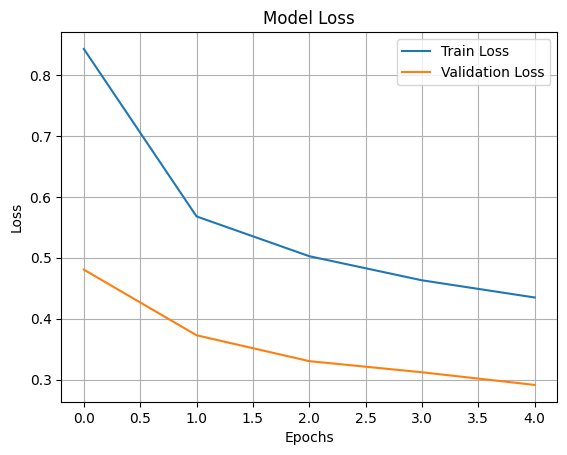

In [14]:
def plot_loss(history):
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)  # No need for history.history, since history is already a dictionary


In [ ]:
import pickle

file_path = r"D:\sdp\sl-two-gpu\history-ilu-gp.pkl"

# Attempt to open and check the contents
try:
    with open(file_path, "rb") as f:
        history = pickle.load(f)
    print("History loaded successfully!")
    print(history.keys())  # Print available keys
except Exception as e:
    print(f"Error loading file: {e}")
import matplotlib.pyplot as plt

def plot_accuracy(history):
    if 'accuracy' in history and 'val_accuracy' in history:
        plt.figure(figsize=(8, 5))
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy')
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Error: Accuracy keys not found in history!")

# Call the function only if history loaded successfully
if history:
    plot_accuracy(history)



History loaded successfully!
History loaded successfully!


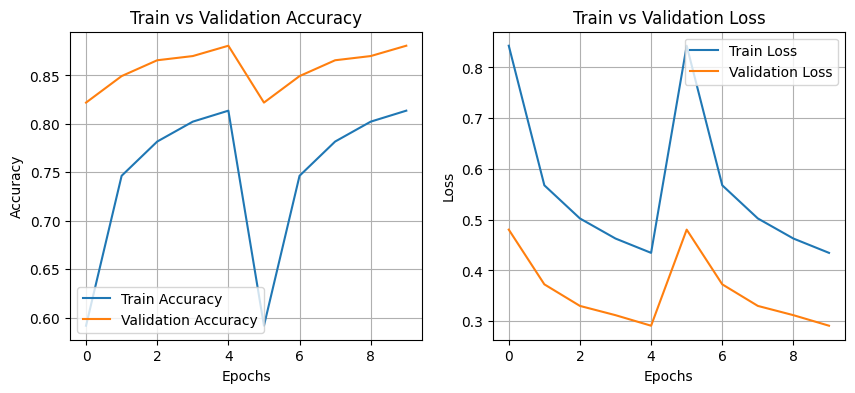

In [17]:
import pickle

file_path = r"D:\sdp\sl-two-gpu\history-ilu-gp.pkl"
file_path_fine = r"D:\sdp\sl-two-gpu\history-ilu-gp.pkl"

with open(file_path, "rb") as f:
    history = pickle.load(f)
print("History loaded successfully!")

with open(file_path_fine, "rb") as f:
    history_fine = pickle.load(f)
print("History loaded successfully!")

def plot_fine_tuning(history, history_fine):
    # Combine accuracy
    acc = history['accuracy'] + history_fine['accuracy']
    val_acc = history['val_accuracy'] + history_fine['val_accuracy']

    # Combine loss
    loss = history['loss'] + history_fine['loss']
    val_loss = history['val_loss'] + history_fine['val_loss']

    epochs_range = range(len(acc))

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid()

    plt.show()

plot_fine_tuning(history, history_fine)

In [ ]:
from keras.api.models import load_model
from keras_preprocessing.image import ImageDataGenerator

loaded_model = load_model('my_model-f-gpu-ilu.h5')

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    r'D:\sdp\redd\test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
loss, accuracy = loaded_model.evaluate(test_generator)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Loss: {loss:.4f}")

import numpy as np
from sklearn.metrics import classification_report

y_true = test_generator.classes

y_pred_probs = loaded_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))